# Connect Three 

__The code develops players for Connect-Three on a grid that is 5 columns wide and 3 rows high. An example is shown below showing a win for Player Red.__

<img src="images/connect3.png" style="width: 200px;"/>

In the Preliminaries we explain how the `Connect` API works. 

## Preliminaries

For your reference, below is a visual description of the agent-environment interface in reinforcment learning. The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$. 

<img src="images/agent-environment.png" style="width: 500px;"/>

<br><br><br>

Below, we provide some code that will be useful for implementing parts of this interface. You are not obligated to use this code; please feel free to develop your own code from scratch. 

### Code details

We provide a `Connect` class that is used to simulate Connect-Three games. The following cells in this section will walk you through the basic usage of this class by playing a couple of games.

We import the `connect` module and create a Connect-Three environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the `Connect` object will regularly print the progress of the game. This is useful for getting to know the provided code, debugging your code, or if you just want to play around. You will want to set `verbose=False` when you run hundreds of episodes to complete the marked exercises.

This `Connect` environment uses the strings `'o'` and `'x'` instead of different disk colors in order to distuingish between the two players.

In [1]:
import connect
env = connect.Connect(starting_player='x', verbose=False)

We can interact with the environment using the act() method. This method takes an action (an integer) as input and computes the response of the environment. An action is defined as the column index that a disk is dropped into. The act() method returns the reward for player 'o' and a boolean, indicating whether the game is over (True) or not (False).

In [2]:
reward, game_over = env.act(action=2)
print("reward =", reward)
print("game_over =", game_over)

reward = 0
game_over = False


Because we set `verbose=True` when we created our environment, the grid is printed each time we call the `act()` method.

As expected, the reward is 0 and no one has won the game yet (game_over is False). Let us drop another disk into the same column.

In [3]:
reward, game_over = env.act(action=2)

We see that the Connect environment automatically changes.

The grid is stored as a two-dimensional numpy array in the Connect class and you can easily access it by calling...

In [4]:
current_grid = env.grid
print(current_grid)

[[' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']]


The attribute .available_actions of the Connect class contains a numpy array of all not yet filled columns. This variable should help you to avoid errors like the one we have just encountered.

In [5]:
print(current_grid[::-1])

[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']]


Let's make another move.

In [6]:
reward, game_over = env.act(action=2)

Let us try to put another disk in the same column with act(action=2). The environment will throw an error because that column is already filled

In [7]:
# This cell should throw an IndexError!
# Uncomment line 3 if you want to try
#env.act(action=2)

The attribute .available_actions of the Connect class contains a numpy array of all not yet filled columns. This variable should help you to avoid errors like the one we have just encountered.

In [8]:
print(env.available_actions)
env.grid[::-1]

[0 1 3 4]


array([[' ', ' ', 'x', ' ', ' '],
       [' ', ' ', 'o', ' ', ' '],
       [' ', ' ', 'x', ' ', ' ']], dtype='<U1')

Note that column index '2' is missing because this column is already filled.

Let's keep on playing until some player wins...

In [9]:
reward, game_over = env.act(action=3)
print("reward =", reward, "game_over =", game_over) 
reward, game_over = env.act(action=1)
print("reward =", reward, "game_over =", game_over)
reward, game_over = env.act(action=3)
print("reward =", reward, "game_over =", game_over)
reward, game_over = env.act(action=1)
print("reward =", reward, "game_over =", game_over)
reward, game_over = env.act(action=3)
print("reward =", reward, "game_over =", game_over)

reward = 0 game_over = False
reward = 0 game_over = False
reward = 0 game_over = False
reward = 0 game_over = False
reward = 1 game_over = True


Note that the reward returned by the act() method is the reward for player 'o'.
You can reset the game using the reset() method. This method cleans the grid and makes sure that the it is the starting_player's turn as defined earlier.

## Part 1: Q-learning

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>

We will prepare a **learning curve** following the directions below. We refer to this as Plot 1.

After  𝑛  steps of interaction with the environment, play  $𝑚$  games with the current policy of the agent (without modifying the policy). Think of this as interrupting the agent for a period of time to test how well it has learned so far. The plot should show the total score obtained in these  𝑚  games as a function of  $𝑛,2𝑛,3𝑛,…𝑘𝑛$ . The choices of  $𝑛$  and  $𝑘$  are up to us. They should be reasonable values that demonstrate the efficiency of the learning and how well the agent learns to play the game eventually. We use $m=10$ .

This plot should show the mean performance of `a` agents, not the performance of a single agent. Because of the stochasticity in the environment, we will obtain two different learning curves from two different agents even though they are using exactly the same algorithm. We suggest setting `a` to 20 or higher.

Present a single mean learning curve with your choice of parameters  𝜖  and  𝛼 . The plot should also show (as a baseline) the mean performance of a random agent that does not learn but chooses actions uniformly randomly from among the legal actions. Label this line “Random Agent”.

We create 3 classes:

**RndPlayer:** To create instances of agents that act randomly. <br />
**QLearning:** A class responsible for fetching and updating of Q-Values in the Q-table.<br />
**QPlayer:** To create instances of agents that use the QTable and act accordingly.

In [10]:
import random

class RndPlayer:

    def choose(self,env):
        return random.choice(env.available_actions)
        

In [11]:
import numpy as np

class QLearning:
   

    def __init__(self):
        self.Qtable = {}
        self.alpha=0.1
        self.gamma=1
        self.epsilon=0.05
        
    def getQ(self,state):
        index = np.array_str(cp.deepcopy(state.grid))
        if not index in self.Qtable:
            self.Qtable[index]=[0,0,0,0,0]
        return self.Qtable[index]
    
    def chooseGreedy(self, state):
        a_a = state.available_actions
        
        if random.random()<self.epsilon:
            return random.choice(a_a)
        return self.getMaxAction(state)
    
    def getMaxAction(self, state):
        q=self.getQ(state)
        a_a = state.available_actions

        maxQ=q[a_a[0]]
        action=a_a[0]
        for i in range(1,len(a_a)):
            if q[a_a[i]]>maxQ:
                maxQ=q[a_a[i]]
                action=a_a[i]
        return action   
        #if(boole):
            #print(a_a)
            #print(q)
            #print(action)
            #print("----------")
     
    
    def getMaxR(self, state):
        return self.getQ(state)[self.getMaxAction(state)]
    
    def updateQ(self, s, a, r, sDash):
        self.getQ(s)[a] = self.getQ(s)[a] + self.alpha*(r+self.gamma*self.getMaxR(sDash)-self.getQ(s)[a])
        
    def updateQTerminal(self,s,a,r):
        self.getQ(s)[a] = self.getQ(s)[a] + self.alpha*(r-self.getQ(s)[a])
        
        
#     def printQtable(self):
#         for i in range(0,len(self.Qtable)):
#             print(self.Qtable[i])

In [12]:
class QPlayer:
    
    def __init__(self,qLearning):
        self.qLearning=qLearning
        
    def choose(self,s):
        return self.qLearning.chooseGreedy(s)
   

    def getMaxAction(self,s):
        return self.qLearning.getMaxAction(s)

__Main Process:__
There is a main game loop in which the Q-Learning player interacts with the environment for n times. When those are exhausted, the learning process pauses and m=10 games are played where the total score is measured.

For the design of the Q-Table, we use a python dictionary which functions like a hash table. The key of each entry is the actual grid while the value is represented by an array of length 5 (one dimension for each column of the board game).

__Parameters:__ *n=500, k=300, m=10, number of agents = 30* <br/>

In [13]:
import connect
import numpy as np
import copy as cp
import matplotlib.pyplot as plt

debug=False
debugt=False

agents=30
kIterations=300
n=500
m=10
learn=True
interactions=0

results = np.zeros(kIterations)

for t in range (0,agents):

    qLearning = QLearning()

    for k in range(0,kIterations):
        
        #Learning
        env = connect.Connect(starting_player = 'x',verbose=debug)
        learn=True
        interactions=0
        
        while learn:
            env.reset()
            if debug:
                print("")

            rndPlayer = RndPlayer()
            qPlayer = QPlayer(qLearning)
            terminal_move=False

            env.act(rndPlayer.choose(env))
            if debug:
                print("")

            s=cp.deepcopy(env)
            while not terminal_move:
                #-------------qPlayer Plays----------------
                a=qPlayer.choose(s)
                r,over = env.act(action=a)

                if r==1:
                    #player won
                    qLearning.updateQTerminal(s,a,r)
                    interactions+=1
                    if interactions==n:
                        learn=False
                    terminal_move=True
                    break;

                if r==0 and env.grid_is_full():
                    qLearning.updateQTerminal(s,a,r)
                    interactions+=1
                    if interactions==n:
                        learn=False
                    terminal_move=True
                    break;
                    
                #env.change_turn()
                if debug:
                    print("")

                #--------------rndPlayer plays-------------
                r,over = env.act(rndPlayer.choose(env))

                if r==-1:
                    qLearning.updateQTerminal(s,a,r)
                    interactions+=1
                    if interactions==n:
                        learn=False
                    terminal_move=True
                    break;
                
                if r == 0 and env.grid_is_full():
                    qLearning.updateQTerminal(s,a,r)
                    interactions+=1
                    if interactions==n:
                        learn=False
                    terminal_move=True
                    break;

                if debug:
                    print("")

                sDash = cp.deepcopy(env)
                r=0
                qLearning.updateQ(s,a,r,sDash)
                interactions+=1
                if interactions==n:
                    learn=False
                    break
                s=sDash



        #Testing
        wins=0;
        losses=0;
        ties=0;
        
        env = connect.Connect(starting_player = 'x',verbose=debugt)
        for i in range (0,m):
            env.reset()
            if debugt:
                print("")

            rndPlayer = RndPlayer()
            qPlayer = QPlayer(qLearning)

            while not env.grid_is_full():
                #--------------rndPlayer plays-------------
                r, over = env.act(rndPlayer.choose(env))
                if r == -1:
                    losses+=1
                    break;
                    

                if debugt:
                    print("")
                    
                if r == 0 and env.grid_is_full():
                    ties+=1
                    break;

                #-------------qPlayer Plays----------------
                r , over = env.act(qPlayer.getMaxAction(env))
                if r == 1:
                    wins+=1
                    break;
                if debugt:
                    print("")
                if r == 0 and env.grid_is_full():
                    ties+=1
                    break;
        
        results[k]+=(wins-losses)
        print("agent: ",t,"      k: ",k," w/l/t ",wins," ",losses," ",ties," score ",wins-losses)

meansQ=results/agents

agent:  0       k:  0  w/l/t  5   5   0  score  0
agent:  0       k:  1  w/l/t  5   5   0  score  0
agent:  0       k:  2  w/l/t  9   1   0  score  8
agent:  0       k:  3  w/l/t  8   2   0  score  6
agent:  0       k:  4  w/l/t  9   1   0  score  8
agent:  0       k:  5  w/l/t  6   4   0  score  2
agent:  0       k:  6  w/l/t  8   2   0  score  6
agent:  0       k:  7  w/l/t  7   3   0  score  4
agent:  0       k:  8  w/l/t  5   5   0  score  0
agent:  0       k:  9  w/l/t  8   2   0  score  6
agent:  0       k:  10  w/l/t  3   7   0  score  -4
agent:  0       k:  11  w/l/t  8   2   0  score  6
agent:  0       k:  12  w/l/t  7   3   0  score  4
agent:  0       k:  13  w/l/t  7   3   0  score  4
agent:  0       k:  14  w/l/t  6   4   0  score  2
agent:  0       k:  15  w/l/t  6   4   0  score  2
agent:  0       k:  16  w/l/t  8   2   0  score  6
agent:  0       k:  17  w/l/t  9   1   0  score  8
agent:  0       k:  18  w/l/t  8   2   0  score  6
agent:  0       k:  19  w/l/t  6   4   0

agent:  0       k:  159  w/l/t  10   0   0  score  10
agent:  0       k:  160  w/l/t  10   0   0  score  10
agent:  0       k:  161  w/l/t  8   2   0  score  6
agent:  0       k:  162  w/l/t  8   2   0  score  6
agent:  0       k:  163  w/l/t  10   0   0  score  10
agent:  0       k:  164  w/l/t  8   2   0  score  6
agent:  0       k:  165  w/l/t  8   2   0  score  6
agent:  0       k:  166  w/l/t  10   0   0  score  10
agent:  0       k:  167  w/l/t  9   1   0  score  8
agent:  0       k:  168  w/l/t  7   3   0  score  4
agent:  0       k:  169  w/l/t  8   2   0  score  6
agent:  0       k:  170  w/l/t  10   0   0  score  10
agent:  0       k:  171  w/l/t  8   2   0  score  6
agent:  0       k:  172  w/l/t  8   2   0  score  6
agent:  0       k:  173  w/l/t  9   1   0  score  8
agent:  0       k:  174  w/l/t  9   1   0  score  8
agent:  0       k:  175  w/l/t  9   1   0  score  8
agent:  0       k:  176  w/l/t  10   0   0  score  10
agent:  0       k:  177  w/l/t  9   1   0  score  8


agent:  1       k:  16  w/l/t  7   3   0  score  4
agent:  1       k:  17  w/l/t  8   2   0  score  6
agent:  1       k:  18  w/l/t  5   4   1  score  1
agent:  1       k:  19  w/l/t  9   1   0  score  8
agent:  1       k:  20  w/l/t  10   0   0  score  10
agent:  1       k:  21  w/l/t  8   2   0  score  6
agent:  1       k:  22  w/l/t  8   2   0  score  6
agent:  1       k:  23  w/l/t  9   1   0  score  8
agent:  1       k:  24  w/l/t  9   1   0  score  8
agent:  1       k:  25  w/l/t  6   4   0  score  2
agent:  1       k:  26  w/l/t  6   4   0  score  2
agent:  1       k:  27  w/l/t  6   4   0  score  2
agent:  1       k:  28  w/l/t  7   3   0  score  4
agent:  1       k:  29  w/l/t  8   2   0  score  6
agent:  1       k:  30  w/l/t  7   2   1  score  5
agent:  1       k:  31  w/l/t  8   2   0  score  6
agent:  1       k:  32  w/l/t  8   2   0  score  6
agent:  1       k:  33  w/l/t  6   4   0  score  2
agent:  1       k:  34  w/l/t  9   1   0  score  8
agent:  1       k:  35  w/l/t

agent:  1       k:  174  w/l/t  9   1   0  score  8
agent:  1       k:  175  w/l/t  10   0   0  score  10
agent:  1       k:  176  w/l/t  8   1   1  score  7
agent:  1       k:  177  w/l/t  9   0   1  score  9
agent:  1       k:  178  w/l/t  8   2   0  score  6
agent:  1       k:  179  w/l/t  9   1   0  score  8
agent:  1       k:  180  w/l/t  8   2   0  score  6
agent:  1       k:  181  w/l/t  8   2   0  score  6
agent:  1       k:  182  w/l/t  9   1   0  score  8
agent:  1       k:  183  w/l/t  9   1   0  score  8
agent:  1       k:  184  w/l/t  9   1   0  score  8
agent:  1       k:  185  w/l/t  9   1   0  score  8
agent:  1       k:  186  w/l/t  6   4   0  score  2
agent:  1       k:  187  w/l/t  10   0   0  score  10
agent:  1       k:  188  w/l/t  7   3   0  score  4
agent:  1       k:  189  w/l/t  9   1   0  score  8
agent:  1       k:  190  w/l/t  9   1   0  score  8
agent:  1       k:  191  w/l/t  8   1   1  score  7
agent:  1       k:  192  w/l/t  8   2   0  score  6
agent:  

agent:  2       k:  32  w/l/t  9   1   0  score  8
agent:  2       k:  33  w/l/t  8   2   0  score  6
agent:  2       k:  34  w/l/t  8   2   0  score  6
agent:  2       k:  35  w/l/t  9   1   0  score  8
agent:  2       k:  36  w/l/t  7   3   0  score  4
agent:  2       k:  37  w/l/t  7   3   0  score  4
agent:  2       k:  38  w/l/t  7   3   0  score  4
agent:  2       k:  39  w/l/t  7   2   1  score  5
agent:  2       k:  40  w/l/t  8   2   0  score  6
agent:  2       k:  41  w/l/t  10   0   0  score  10
agent:  2       k:  42  w/l/t  4   6   0  score  -2
agent:  2       k:  43  w/l/t  8   2   0  score  6
agent:  2       k:  44  w/l/t  8   2   0  score  6
agent:  2       k:  45  w/l/t  8   2   0  score  6
agent:  2       k:  46  w/l/t  8   2   0  score  6
agent:  2       k:  47  w/l/t  8   2   0  score  6
agent:  2       k:  48  w/l/t  6   4   0  score  2
agent:  2       k:  49  w/l/t  7   2   1  score  5
agent:  2       k:  50  w/l/t  10   0   0  score  10
agent:  2       k:  51  w/

agent:  2       k:  190  w/l/t  10   0   0  score  10
agent:  2       k:  191  w/l/t  10   0   0  score  10
agent:  2       k:  192  w/l/t  9   1   0  score  8
agent:  2       k:  193  w/l/t  9   1   0  score  8
agent:  2       k:  194  w/l/t  10   0   0  score  10
agent:  2       k:  195  w/l/t  8   2   0  score  6
agent:  2       k:  196  w/l/t  7   2   1  score  5
agent:  2       k:  197  w/l/t  8   2   0  score  6
agent:  2       k:  198  w/l/t  10   0   0  score  10
agent:  2       k:  199  w/l/t  10   0   0  score  10
agent:  2       k:  200  w/l/t  8   2   0  score  6
agent:  2       k:  201  w/l/t  7   3   0  score  4
agent:  2       k:  202  w/l/t  9   1   0  score  8
agent:  2       k:  203  w/l/t  10   0   0  score  10
agent:  2       k:  204  w/l/t  8   2   0  score  6
agent:  2       k:  205  w/l/t  10   0   0  score  10
agent:  2       k:  206  w/l/t  8   2   0  score  6
agent:  2       k:  207  w/l/t  9   1   0  score  8
agent:  2       k:  208  w/l/t  10   0   0  score 

agent:  3       k:  48  w/l/t  8   2   0  score  6
agent:  3       k:  49  w/l/t  9   1   0  score  8
agent:  3       k:  50  w/l/t  8   2   0  score  6
agent:  3       k:  51  w/l/t  7   3   0  score  4
agent:  3       k:  52  w/l/t  7   2   1  score  5
agent:  3       k:  53  w/l/t  8   2   0  score  6
agent:  3       k:  54  w/l/t  7   3   0  score  4
agent:  3       k:  55  w/l/t  8   2   0  score  6
agent:  3       k:  56  w/l/t  9   1   0  score  8
agent:  3       k:  57  w/l/t  9   1   0  score  8
agent:  3       k:  58  w/l/t  9   1   0  score  8
agent:  3       k:  59  w/l/t  8   2   0  score  6
agent:  3       k:  60  w/l/t  10   0   0  score  10
agent:  3       k:  61  w/l/t  8   2   0  score  6
agent:  3       k:  62  w/l/t  6   4   0  score  2
agent:  3       k:  63  w/l/t  7   3   0  score  4
agent:  3       k:  64  w/l/t  8   2   0  score  6
agent:  3       k:  65  w/l/t  6   4   0  score  2
agent:  3       k:  66  w/l/t  9   1   0  score  8
agent:  3       k:  67  w/l/t

agent:  3       k:  206  w/l/t  10   0   0  score  10
agent:  3       k:  207  w/l/t  6   4   0  score  2
agent:  3       k:  208  w/l/t  6   3   1  score  3
agent:  3       k:  209  w/l/t  9   1   0  score  8
agent:  3       k:  210  w/l/t  7   2   1  score  5
agent:  3       k:  211  w/l/t  8   2   0  score  6
agent:  3       k:  212  w/l/t  9   1   0  score  8
agent:  3       k:  213  w/l/t  8   2   0  score  6
agent:  3       k:  214  w/l/t  10   0   0  score  10
agent:  3       k:  215  w/l/t  7   3   0  score  4
agent:  3       k:  216  w/l/t  7   3   0  score  4
agent:  3       k:  217  w/l/t  9   1   0  score  8
agent:  3       k:  218  w/l/t  7   3   0  score  4
agent:  3       k:  219  w/l/t  9   1   0  score  8
agent:  3       k:  220  w/l/t  9   1   0  score  8
agent:  3       k:  221  w/l/t  8   1   1  score  7
agent:  3       k:  222  w/l/t  7   3   0  score  4
agent:  3       k:  223  w/l/t  9   1   0  score  8
agent:  3       k:  224  w/l/t  10   0   0  score  10
agent:

agent:  4       k:  64  w/l/t  7   3   0  score  4
agent:  4       k:  65  w/l/t  9   1   0  score  8
agent:  4       k:  66  w/l/t  9   1   0  score  8
agent:  4       k:  67  w/l/t  8   2   0  score  6
agent:  4       k:  68  w/l/t  7   3   0  score  4
agent:  4       k:  69  w/l/t  10   0   0  score  10
agent:  4       k:  70  w/l/t  10   0   0  score  10
agent:  4       k:  71  w/l/t  7   3   0  score  4
agent:  4       k:  72  w/l/t  8   2   0  score  6
agent:  4       k:  73  w/l/t  9   0   1  score  9
agent:  4       k:  74  w/l/t  9   1   0  score  8
agent:  4       k:  75  w/l/t  9   1   0  score  8
agent:  4       k:  76  w/l/t  9   1   0  score  8
agent:  4       k:  77  w/l/t  8   1   1  score  7
agent:  4       k:  78  w/l/t  9   1   0  score  8
agent:  4       k:  79  w/l/t  8   1   1  score  7
agent:  4       k:  80  w/l/t  7   3   0  score  4
agent:  4       k:  81  w/l/t  9   1   0  score  8
agent:  4       k:  82  w/l/t  7   2   1  score  5
agent:  4       k:  83  w/l

agent:  4       k:  222  w/l/t  10   0   0  score  10
agent:  4       k:  223  w/l/t  10   0   0  score  10
agent:  4       k:  224  w/l/t  9   1   0  score  8
agent:  4       k:  225  w/l/t  9   1   0  score  8
agent:  4       k:  226  w/l/t  10   0   0  score  10
agent:  4       k:  227  w/l/t  10   0   0  score  10
agent:  4       k:  228  w/l/t  10   0   0  score  10
agent:  4       k:  229  w/l/t  8   2   0  score  6
agent:  4       k:  230  w/l/t  10   0   0  score  10
agent:  4       k:  231  w/l/t  10   0   0  score  10
agent:  4       k:  232  w/l/t  9   1   0  score  8
agent:  4       k:  233  w/l/t  10   0   0  score  10
agent:  4       k:  234  w/l/t  8   2   0  score  6
agent:  4       k:  235  w/l/t  8   2   0  score  6
agent:  4       k:  236  w/l/t  8   2   0  score  6
agent:  4       k:  237  w/l/t  10   0   0  score  10
agent:  4       k:  238  w/l/t  10   0   0  score  10
agent:  4       k:  239  w/l/t  9   1   0  score  8
agent:  4       k:  240  w/l/t  9   1   0  s

agent:  5       k:  80  w/l/t  9   1   0  score  8
agent:  5       k:  81  w/l/t  6   4   0  score  2
agent:  5       k:  82  w/l/t  9   1   0  score  8
agent:  5       k:  83  w/l/t  9   1   0  score  8
agent:  5       k:  84  w/l/t  7   3   0  score  4
agent:  5       k:  85  w/l/t  7   2   1  score  5
agent:  5       k:  86  w/l/t  8   2   0  score  6
agent:  5       k:  87  w/l/t  8   2   0  score  6
agent:  5       k:  88  w/l/t  7   3   0  score  4
agent:  5       k:  89  w/l/t  8   2   0  score  6
agent:  5       k:  90  w/l/t  8   1   1  score  7
agent:  5       k:  91  w/l/t  8   2   0  score  6
agent:  5       k:  92  w/l/t  7   3   0  score  4
agent:  5       k:  93  w/l/t  8   2   0  score  6
agent:  5       k:  94  w/l/t  9   1   0  score  8
agent:  5       k:  95  w/l/t  8   2   0  score  6
agent:  5       k:  96  w/l/t  7   3   0  score  4
agent:  5       k:  97  w/l/t  9   0   1  score  9
agent:  5       k:  98  w/l/t  8   2   0  score  6
agent:  5       k:  99  w/l/t  

agent:  5       k:  237  w/l/t  10   0   0  score  10
agent:  5       k:  238  w/l/t  9   1   0  score  8
agent:  5       k:  239  w/l/t  8   2   0  score  6
agent:  5       k:  240  w/l/t  8   2   0  score  6
agent:  5       k:  241  w/l/t  9   1   0  score  8
agent:  5       k:  242  w/l/t  10   0   0  score  10
agent:  5       k:  243  w/l/t  8   2   0  score  6
agent:  5       k:  244  w/l/t  10   0   0  score  10
agent:  5       k:  245  w/l/t  9   1   0  score  8
agent:  5       k:  246  w/l/t  9   0   1  score  9
agent:  5       k:  247  w/l/t  10   0   0  score  10
agent:  5       k:  248  w/l/t  10   0   0  score  10
agent:  5       k:  249  w/l/t  7   3   0  score  4
agent:  5       k:  250  w/l/t  9   0   1  score  9
agent:  5       k:  251  w/l/t  9   1   0  score  8
agent:  5       k:  252  w/l/t  10   0   0  score  10
agent:  5       k:  253  w/l/t  9   1   0  score  8
agent:  5       k:  254  w/l/t  8   1   1  score  7
agent:  5       k:  255  w/l/t  9   1   0  score  8


agent:  6       k:  96  w/l/t  6   4   0  score  2
agent:  6       k:  97  w/l/t  8   2   0  score  6
agent:  6       k:  98  w/l/t  7   2   1  score  5
agent:  6       k:  99  w/l/t  10   0   0  score  10
agent:  6       k:  100  w/l/t  10   0   0  score  10
agent:  6       k:  101  w/l/t  9   1   0  score  8
agent:  6       k:  102  w/l/t  8   2   0  score  6
agent:  6       k:  103  w/l/t  9   1   0  score  8
agent:  6       k:  104  w/l/t  7   3   0  score  4
agent:  6       k:  105  w/l/t  8   2   0  score  6
agent:  6       k:  106  w/l/t  9   1   0  score  8
agent:  6       k:  107  w/l/t  8   2   0  score  6
agent:  6       k:  108  w/l/t  9   1   0  score  8
agent:  6       k:  109  w/l/t  9   1   0  score  8
agent:  6       k:  110  w/l/t  8   2   0  score  6
agent:  6       k:  111  w/l/t  5   5   0  score  0
agent:  6       k:  112  w/l/t  7   3   0  score  4
agent:  6       k:  113  w/l/t  10   0   0  score  10
agent:  6       k:  114  w/l/t  9   1   0  score  8
agent:  6 

agent:  6       k:  253  w/l/t  8   2   0  score  6
agent:  6       k:  254  w/l/t  10   0   0  score  10
agent:  6       k:  255  w/l/t  8   2   0  score  6
agent:  6       k:  256  w/l/t  10   0   0  score  10
agent:  6       k:  257  w/l/t  9   1   0  score  8
agent:  6       k:  258  w/l/t  10   0   0  score  10
agent:  6       k:  259  w/l/t  9   1   0  score  8
agent:  6       k:  260  w/l/t  8   2   0  score  6
agent:  6       k:  261  w/l/t  9   1   0  score  8
agent:  6       k:  262  w/l/t  10   0   0  score  10
agent:  6       k:  263  w/l/t  9   1   0  score  8
agent:  6       k:  264  w/l/t  9   1   0  score  8
agent:  6       k:  265  w/l/t  9   1   0  score  8
agent:  6       k:  266  w/l/t  10   0   0  score  10
agent:  6       k:  267  w/l/t  10   0   0  score  10
agent:  6       k:  268  w/l/t  9   1   0  score  8
agent:  6       k:  269  w/l/t  8   2   0  score  6
agent:  6       k:  270  w/l/t  8   1   1  score  7
agent:  6       k:  271  w/l/t  6   4   0  score  2


agent:  7       k:  112  w/l/t  9   0   1  score  9
agent:  7       k:  113  w/l/t  10   0   0  score  10
agent:  7       k:  114  w/l/t  9   1   0  score  8
agent:  7       k:  115  w/l/t  10   0   0  score  10
agent:  7       k:  116  w/l/t  10   0   0  score  10
agent:  7       k:  117  w/l/t  9   1   0  score  8
agent:  7       k:  118  w/l/t  9   1   0  score  8
agent:  7       k:  119  w/l/t  9   1   0  score  8
agent:  7       k:  120  w/l/t  8   2   0  score  6
agent:  7       k:  121  w/l/t  5   5   0  score  0
agent:  7       k:  122  w/l/t  8   2   0  score  6
agent:  7       k:  123  w/l/t  9   1   0  score  8
agent:  7       k:  124  w/l/t  8   2   0  score  6
agent:  7       k:  125  w/l/t  7   3   0  score  4
agent:  7       k:  126  w/l/t  8   2   0  score  6
agent:  7       k:  127  w/l/t  9   1   0  score  8
agent:  7       k:  128  w/l/t  7   2   1  score  5
agent:  7       k:  129  w/l/t  8   2   0  score  6
agent:  7       k:  130  w/l/t  9   0   1  score  9
agent:

agent:  7       k:  269  w/l/t  9   1   0  score  8
agent:  7       k:  270  w/l/t  10   0   0  score  10
agent:  7       k:  271  w/l/t  9   1   0  score  8
agent:  7       k:  272  w/l/t  10   0   0  score  10
agent:  7       k:  273  w/l/t  7   2   1  score  5
agent:  7       k:  274  w/l/t  9   1   0  score  8
agent:  7       k:  275  w/l/t  8   2   0  score  6
agent:  7       k:  276  w/l/t  9   1   0  score  8
agent:  7       k:  277  w/l/t  8   2   0  score  6
agent:  7       k:  278  w/l/t  8   2   0  score  6
agent:  7       k:  279  w/l/t  10   0   0  score  10
agent:  7       k:  280  w/l/t  10   0   0  score  10
agent:  7       k:  281  w/l/t  9   1   0  score  8
agent:  7       k:  282  w/l/t  9   1   0  score  8
agent:  7       k:  283  w/l/t  7   3   0  score  4
agent:  7       k:  284  w/l/t  9   1   0  score  8
agent:  7       k:  285  w/l/t  9   1   0  score  8
agent:  7       k:  286  w/l/t  9   1   0  score  8
agent:  7       k:  287  w/l/t  9   1   0  score  8
agen

agent:  8       k:  128  w/l/t  8   2   0  score  6
agent:  8       k:  129  w/l/t  7   3   0  score  4
agent:  8       k:  130  w/l/t  10   0   0  score  10
agent:  8       k:  131  w/l/t  10   0   0  score  10
agent:  8       k:  132  w/l/t  9   1   0  score  8
agent:  8       k:  133  w/l/t  8   2   0  score  6
agent:  8       k:  134  w/l/t  8   2   0  score  6
agent:  8       k:  135  w/l/t  9   1   0  score  8
agent:  8       k:  136  w/l/t  9   1   0  score  8
agent:  8       k:  137  w/l/t  10   0   0  score  10
agent:  8       k:  138  w/l/t  6   4   0  score  2
agent:  8       k:  139  w/l/t  8   2   0  score  6
agent:  8       k:  140  w/l/t  6   4   0  score  2
agent:  8       k:  141  w/l/t  9   1   0  score  8
agent:  8       k:  142  w/l/t  9   1   0  score  8
agent:  8       k:  143  w/l/t  9   0   1  score  9
agent:  8       k:  144  w/l/t  9   1   0  score  8
agent:  8       k:  145  w/l/t  9   1   0  score  8
agent:  8       k:  146  w/l/t  10   0   0  score  10
agen

agent:  8       k:  285  w/l/t  8   1   1  score  7
agent:  8       k:  286  w/l/t  9   1   0  score  8
agent:  8       k:  287  w/l/t  9   1   0  score  8
agent:  8       k:  288  w/l/t  9   1   0  score  8
agent:  8       k:  289  w/l/t  10   0   0  score  10
agent:  8       k:  290  w/l/t  8   2   0  score  6
agent:  8       k:  291  w/l/t  10   0   0  score  10
agent:  8       k:  292  w/l/t  9   1   0  score  8
agent:  8       k:  293  w/l/t  9   1   0  score  8
agent:  8       k:  294  w/l/t  9   1   0  score  8
agent:  8       k:  295  w/l/t  9   1   0  score  8
agent:  8       k:  296  w/l/t  8   1   1  score  7
agent:  8       k:  297  w/l/t  9   1   0  score  8
agent:  8       k:  298  w/l/t  9   1   0  score  8
agent:  8       k:  299  w/l/t  10   0   0  score  10
agent:  9       k:  0  w/l/t  4   6   0  score  -2
agent:  9       k:  1  w/l/t  4   6   0  score  -2
agent:  9       k:  2  w/l/t  6   4   0  score  2
agent:  9       k:  3  w/l/t  4   6   0  score  -2
agent:  9  

agent:  9       k:  145  w/l/t  10   0   0  score  10
agent:  9       k:  146  w/l/t  9   1   0  score  8
agent:  9       k:  147  w/l/t  9   1   0  score  8
agent:  9       k:  148  w/l/t  9   1   0  score  8
agent:  9       k:  149  w/l/t  9   1   0  score  8
agent:  9       k:  150  w/l/t  9   1   0  score  8
agent:  9       k:  151  w/l/t  10   0   0  score  10
agent:  9       k:  152  w/l/t  9   1   0  score  8
agent:  9       k:  153  w/l/t  8   2   0  score  6
agent:  9       k:  154  w/l/t  4   6   0  score  -2
agent:  9       k:  155  w/l/t  7   2   1  score  5
agent:  9       k:  156  w/l/t  6   3   1  score  3
agent:  9       k:  157  w/l/t  10   0   0  score  10
agent:  9       k:  158  w/l/t  9   1   0  score  8
agent:  9       k:  159  w/l/t  9   1   0  score  8
agent:  9       k:  160  w/l/t  9   1   0  score  8
agent:  9       k:  161  w/l/t  9   1   0  score  8
agent:  9       k:  162  w/l/t  9   1   0  score  8
agent:  9       k:  163  w/l/t  7   2   1  score  5
agent

agent:  10       k:  2  w/l/t  5   5   0  score  0
agent:  10       k:  3  w/l/t  5   5   0  score  0
agent:  10       k:  4  w/l/t  2   8   0  score  -6
agent:  10       k:  5  w/l/t  7   3   0  score  4
agent:  10       k:  6  w/l/t  6   4   0  score  2
agent:  10       k:  7  w/l/t  7   3   0  score  4
agent:  10       k:  8  w/l/t  10   0   0  score  10
agent:  10       k:  9  w/l/t  6   4   0  score  2
agent:  10       k:  10  w/l/t  6   4   0  score  2
agent:  10       k:  11  w/l/t  7   3   0  score  4
agent:  10       k:  12  w/l/t  5   4   1  score  1
agent:  10       k:  13  w/l/t  5   5   0  score  0
agent:  10       k:  14  w/l/t  8   2   0  score  6
agent:  10       k:  15  w/l/t  8   2   0  score  6
agent:  10       k:  16  w/l/t  5   5   0  score  0
agent:  10       k:  17  w/l/t  6   4   0  score  2
agent:  10       k:  18  w/l/t  6   4   0  score  2
agent:  10       k:  19  w/l/t  9   1   0  score  8
agent:  10       k:  20  w/l/t  6   4   0  score  2
agent:  10       

agent:  10       k:  159  w/l/t  10   0   0  score  10
agent:  10       k:  160  w/l/t  9   1   0  score  8
agent:  10       k:  161  w/l/t  9   1   0  score  8
agent:  10       k:  162  w/l/t  10   0   0  score  10
agent:  10       k:  163  w/l/t  9   1   0  score  8
agent:  10       k:  164  w/l/t  8   2   0  score  6
agent:  10       k:  165  w/l/t  8   2   0  score  6
agent:  10       k:  166  w/l/t  9   1   0  score  8
agent:  10       k:  167  w/l/t  8   2   0  score  6
agent:  10       k:  168  w/l/t  8   2   0  score  6
agent:  10       k:  169  w/l/t  9   1   0  score  8
agent:  10       k:  170  w/l/t  8   2   0  score  6
agent:  10       k:  171  w/l/t  9   1   0  score  8
agent:  10       k:  172  w/l/t  9   1   0  score  8
agent:  10       k:  173  w/l/t  10   0   0  score  10
agent:  10       k:  174  w/l/t  7   2   1  score  5
agent:  10       k:  175  w/l/t  10   0   0  score  10
agent:  10       k:  176  w/l/t  9   1   0  score  8
agent:  10       k:  177  w/l/t  9   1

agent:  11       k:  13  w/l/t  9   1   0  score  8
agent:  11       k:  14  w/l/t  6   4   0  score  2
agent:  11       k:  15  w/l/t  3   7   0  score  -4
agent:  11       k:  16  w/l/t  6   4   0  score  2
agent:  11       k:  17  w/l/t  8   2   0  score  6
agent:  11       k:  18  w/l/t  7   3   0  score  4
agent:  11       k:  19  w/l/t  9   1   0  score  8
agent:  11       k:  20  w/l/t  8   2   0  score  6
agent:  11       k:  21  w/l/t  10   0   0  score  10
agent:  11       k:  22  w/l/t  8   2   0  score  6
agent:  11       k:  23  w/l/t  9   1   0  score  8
agent:  11       k:  24  w/l/t  6   3   1  score  3
agent:  11       k:  25  w/l/t  7   3   0  score  4
agent:  11       k:  26  w/l/t  8   2   0  score  6
agent:  11       k:  27  w/l/t  9   1   0  score  8
agent:  11       k:  28  w/l/t  8   2   0  score  6
agent:  11       k:  29  w/l/t  7   3   0  score  4
agent:  11       k:  30  w/l/t  6   4   0  score  2
agent:  11       k:  31  w/l/t  6   4   0  score  2
agent:  1

agent:  11       k:  169  w/l/t  9   1   0  score  8
agent:  11       k:  170  w/l/t  7   3   0  score  4
agent:  11       k:  171  w/l/t  8   2   0  score  6
agent:  11       k:  172  w/l/t  9   1   0  score  8
agent:  11       k:  173  w/l/t  8   1   1  score  7
agent:  11       k:  174  w/l/t  9   1   0  score  8
agent:  11       k:  175  w/l/t  9   1   0  score  8
agent:  11       k:  176  w/l/t  5   5   0  score  0
agent:  11       k:  177  w/l/t  9   1   0  score  8
agent:  11       k:  178  w/l/t  8   2   0  score  6
agent:  11       k:  179  w/l/t  8   2   0  score  6
agent:  11       k:  180  w/l/t  10   0   0  score  10
agent:  11       k:  181  w/l/t  9   1   0  score  8
agent:  11       k:  182  w/l/t  9   1   0  score  8
agent:  11       k:  183  w/l/t  8   2   0  score  6
agent:  11       k:  184  w/l/t  8   2   0  score  6
agent:  11       k:  185  w/l/t  8   2   0  score  6
agent:  11       k:  186  w/l/t  8   2   0  score  6
agent:  11       k:  187  w/l/t  7   2   1  

agent:  12       k:  24  w/l/t  6   4   0  score  2
agent:  12       k:  25  w/l/t  7   3   0  score  4
agent:  12       k:  26  w/l/t  8   2   0  score  6
agent:  12       k:  27  w/l/t  8   2   0  score  6
agent:  12       k:  28  w/l/t  7   2   1  score  5
agent:  12       k:  29  w/l/t  8   2   0  score  6
agent:  12       k:  30  w/l/t  8   2   0  score  6
agent:  12       k:  31  w/l/t  8   2   0  score  6
agent:  12       k:  32  w/l/t  10   0   0  score  10
agent:  12       k:  33  w/l/t  9   1   0  score  8
agent:  12       k:  34  w/l/t  8   2   0  score  6
agent:  12       k:  35  w/l/t  7   3   0  score  4
agent:  12       k:  36  w/l/t  7   3   0  score  4
agent:  12       k:  37  w/l/t  8   2   0  score  6
agent:  12       k:  38  w/l/t  8   2   0  score  6
agent:  12       k:  39  w/l/t  8   2   0  score  6
agent:  12       k:  40  w/l/t  8   2   0  score  6
agent:  12       k:  41  w/l/t  10   0   0  score  10
agent:  12       k:  42  w/l/t  9   1   0  score  8
agent:  

agent:  12       k:  179  w/l/t  9   1   0  score  8
agent:  12       k:  180  w/l/t  6   3   1  score  3
agent:  12       k:  181  w/l/t  8   2   0  score  6
agent:  12       k:  182  w/l/t  8   2   0  score  6
agent:  12       k:  183  w/l/t  9   1   0  score  8
agent:  12       k:  184  w/l/t  8   2   0  score  6
agent:  12       k:  185  w/l/t  9   1   0  score  8
agent:  12       k:  186  w/l/t  8   2   0  score  6
agent:  12       k:  187  w/l/t  9   1   0  score  8
agent:  12       k:  188  w/l/t  10   0   0  score  10
agent:  12       k:  189  w/l/t  9   1   0  score  8
agent:  12       k:  190  w/l/t  10   0   0  score  10
agent:  12       k:  191  w/l/t  8   2   0  score  6
agent:  12       k:  192  w/l/t  8   2   0  score  6
agent:  12       k:  193  w/l/t  9   1   0  score  8
agent:  12       k:  194  w/l/t  6   4   0  score  2
agent:  12       k:  195  w/l/t  10   0   0  score  10
agent:  12       k:  196  w/l/t  9   1   0  score  8
agent:  12       k:  197  w/l/t  7   3  

agent:  13       k:  34  w/l/t  8   2   0  score  6
agent:  13       k:  35  w/l/t  8   2   0  score  6
agent:  13       k:  36  w/l/t  9   1   0  score  8
agent:  13       k:  37  w/l/t  6   4   0  score  2
agent:  13       k:  38  w/l/t  8   2   0  score  6
agent:  13       k:  39  w/l/t  9   1   0  score  8
agent:  13       k:  40  w/l/t  9   1   0  score  8
agent:  13       k:  41  w/l/t  8   2   0  score  6
agent:  13       k:  42  w/l/t  8   2   0  score  6
agent:  13       k:  43  w/l/t  7   3   0  score  4
agent:  13       k:  44  w/l/t  6   4   0  score  2
agent:  13       k:  45  w/l/t  8   2   0  score  6
agent:  13       k:  46  w/l/t  7   3   0  score  4
agent:  13       k:  47  w/l/t  9   1   0  score  8
agent:  13       k:  48  w/l/t  8   1   1  score  7
agent:  13       k:  49  w/l/t  8   2   0  score  6
agent:  13       k:  50  w/l/t  9   1   0  score  8
agent:  13       k:  51  w/l/t  7   3   0  score  4
agent:  13       k:  52  w/l/t  8   2   0  score  6
agent:  13  

agent:  13       k:  189  w/l/t  8   2   0  score  6
agent:  13       k:  190  w/l/t  7   2   1  score  5
agent:  13       k:  191  w/l/t  8   1   1  score  7
agent:  13       k:  192  w/l/t  7   3   0  score  4
agent:  13       k:  193  w/l/t  8   2   0  score  6
agent:  13       k:  194  w/l/t  9   1   0  score  8
agent:  13       k:  195  w/l/t  9   1   0  score  8
agent:  13       k:  196  w/l/t  8   2   0  score  6
agent:  13       k:  197  w/l/t  9   1   0  score  8
agent:  13       k:  198  w/l/t  8   2   0  score  6
agent:  13       k:  199  w/l/t  8   2   0  score  6
agent:  13       k:  200  w/l/t  8   2   0  score  6
agent:  13       k:  201  w/l/t  9   1   0  score  8
agent:  13       k:  202  w/l/t  8   2   0  score  6
agent:  13       k:  203  w/l/t  9   1   0  score  8
agent:  13       k:  204  w/l/t  9   1   0  score  8
agent:  13       k:  205  w/l/t  7   2   1  score  5
agent:  13       k:  206  w/l/t  8   2   0  score  6
agent:  13       k:  207  w/l/t  9   1   0  sc

agent:  14       k:  44  w/l/t  8   2   0  score  6
agent:  14       k:  45  w/l/t  8   2   0  score  6
agent:  14       k:  46  w/l/t  6   4   0  score  2
agent:  14       k:  47  w/l/t  7   3   0  score  4
agent:  14       k:  48  w/l/t  8   2   0  score  6
agent:  14       k:  49  w/l/t  7   3   0  score  4
agent:  14       k:  50  w/l/t  8   2   0  score  6
agent:  14       k:  51  w/l/t  10   0   0  score  10
agent:  14       k:  52  w/l/t  10   0   0  score  10
agent:  14       k:  53  w/l/t  9   1   0  score  8
agent:  14       k:  54  w/l/t  6   4   0  score  2
agent:  14       k:  55  w/l/t  9   1   0  score  8
agent:  14       k:  56  w/l/t  9   1   0  score  8
agent:  14       k:  57  w/l/t  9   1   0  score  8
agent:  14       k:  58  w/l/t  9   1   0  score  8
agent:  14       k:  59  w/l/t  8   2   0  score  6
agent:  14       k:  60  w/l/t  5   5   0  score  0
agent:  14       k:  61  w/l/t  9   1   0  score  8
agent:  14       k:  62  w/l/t  8   2   0  score  6
agent:  

agent:  14       k:  199  w/l/t  8   1   1  score  7
agent:  14       k:  200  w/l/t  9   1   0  score  8
agent:  14       k:  201  w/l/t  9   1   0  score  8
agent:  14       k:  202  w/l/t  9   0   1  score  9
agent:  14       k:  203  w/l/t  8   2   0  score  6
agent:  14       k:  204  w/l/t  8   2   0  score  6
agent:  14       k:  205  w/l/t  9   1   0  score  8
agent:  14       k:  206  w/l/t  10   0   0  score  10
agent:  14       k:  207  w/l/t  9   1   0  score  8
agent:  14       k:  208  w/l/t  10   0   0  score  10
agent:  14       k:  209  w/l/t  9   1   0  score  8
agent:  14       k:  210  w/l/t  9   1   0  score  8
agent:  14       k:  211  w/l/t  9   1   0  score  8
agent:  14       k:  212  w/l/t  8   1   1  score  7
agent:  14       k:  213  w/l/t  9   1   0  score  8
agent:  14       k:  214  w/l/t  9   1   0  score  8
agent:  14       k:  215  w/l/t  8   2   0  score  6
agent:  14       k:  216  w/l/t  10   0   0  score  10
agent:  14       k:  217  w/l/t  8   2  

agent:  15       k:  54  w/l/t  10   0   0  score  10
agent:  15       k:  55  w/l/t  8   2   0  score  6
agent:  15       k:  56  w/l/t  8   2   0  score  6
agent:  15       k:  57  w/l/t  7   3   0  score  4
agent:  15       k:  58  w/l/t  7   3   0  score  4
agent:  15       k:  59  w/l/t  9   1   0  score  8
agent:  15       k:  60  w/l/t  9   1   0  score  8
agent:  15       k:  61  w/l/t  10   0   0  score  10
agent:  15       k:  62  w/l/t  9   1   0  score  8
agent:  15       k:  63  w/l/t  7   3   0  score  4
agent:  15       k:  64  w/l/t  9   1   0  score  8
agent:  15       k:  65  w/l/t  7   3   0  score  4
agent:  15       k:  66  w/l/t  7   3   0  score  4
agent:  15       k:  67  w/l/t  7   3   0  score  4
agent:  15       k:  68  w/l/t  7   3   0  score  4
agent:  15       k:  69  w/l/t  9   1   0  score  8
agent:  15       k:  70  w/l/t  7   3   0  score  4
agent:  15       k:  71  w/l/t  9   0   1  score  9
agent:  15       k:  72  w/l/t  9   1   0  score  8
agent:  

agent:  15       k:  209  w/l/t  7   3   0  score  4
agent:  15       k:  210  w/l/t  9   1   0  score  8
agent:  15       k:  211  w/l/t  9   1   0  score  8
agent:  15       k:  212  w/l/t  10   0   0  score  10
agent:  15       k:  213  w/l/t  8   2   0  score  6
agent:  15       k:  214  w/l/t  9   0   1  score  9
agent:  15       k:  215  w/l/t  7   3   0  score  4
agent:  15       k:  216  w/l/t  8   1   1  score  7
agent:  15       k:  217  w/l/t  9   1   0  score  8
agent:  15       k:  218  w/l/t  7   3   0  score  4
agent:  15       k:  219  w/l/t  7   3   0  score  4
agent:  15       k:  220  w/l/t  8   2   0  score  6
agent:  15       k:  221  w/l/t  6   3   1  score  3
agent:  15       k:  222  w/l/t  9   1   0  score  8
agent:  15       k:  223  w/l/t  9   1   0  score  8
agent:  15       k:  224  w/l/t  10   0   0  score  10
agent:  15       k:  225  w/l/t  9   1   0  score  8
agent:  15       k:  226  w/l/t  9   1   0  score  8
agent:  15       k:  227  w/l/t  10   0   

agent:  16       k:  65  w/l/t  8   2   0  score  6
agent:  16       k:  66  w/l/t  7   3   0  score  4
agent:  16       k:  67  w/l/t  9   1   0  score  8
agent:  16       k:  68  w/l/t  8   2   0  score  6
agent:  16       k:  69  w/l/t  8   2   0  score  6
agent:  16       k:  70  w/l/t  9   1   0  score  8
agent:  16       k:  71  w/l/t  10   0   0  score  10
agent:  16       k:  72  w/l/t  5   4   1  score  1
agent:  16       k:  73  w/l/t  8   2   0  score  6
agent:  16       k:  74  w/l/t  7   3   0  score  4
agent:  16       k:  75  w/l/t  8   1   1  score  7
agent:  16       k:  76  w/l/t  9   1   0  score  8
agent:  16       k:  77  w/l/t  6   4   0  score  2
agent:  16       k:  78  w/l/t  8   2   0  score  6
agent:  16       k:  79  w/l/t  8   2   0  score  6
agent:  16       k:  80  w/l/t  8   1   1  score  7
agent:  16       k:  81  w/l/t  8   2   0  score  6
agent:  16       k:  82  w/l/t  10   0   0  score  10
agent:  16       k:  83  w/l/t  8   2   0  score  6
agent:  

agent:  16       k:  220  w/l/t  10   0   0  score  10
agent:  16       k:  221  w/l/t  7   3   0  score  4
agent:  16       k:  222  w/l/t  9   1   0  score  8
agent:  16       k:  223  w/l/t  7   3   0  score  4
agent:  16       k:  224  w/l/t  7   2   1  score  5
agent:  16       k:  225  w/l/t  10   0   0  score  10
agent:  16       k:  226  w/l/t  9   1   0  score  8
agent:  16       k:  227  w/l/t  9   1   0  score  8
agent:  16       k:  228  w/l/t  10   0   0  score  10
agent:  16       k:  229  w/l/t  10   0   0  score  10
agent:  16       k:  230  w/l/t  8   2   0  score  6
agent:  16       k:  231  w/l/t  9   1   0  score  8
agent:  16       k:  232  w/l/t  8   2   0  score  6
agent:  16       k:  233  w/l/t  9   1   0  score  8
agent:  16       k:  234  w/l/t  7   2   1  score  5
agent:  16       k:  235  w/l/t  7   3   0  score  4
agent:  16       k:  236  w/l/t  8   2   0  score  6
agent:  16       k:  237  w/l/t  9   1   0  score  8
agent:  16       k:  238  w/l/t  8   2

agent:  17       k:  76  w/l/t  7   2   1  score  5
agent:  17       k:  77  w/l/t  9   1   0  score  8
agent:  17       k:  78  w/l/t  9   1   0  score  8
agent:  17       k:  79  w/l/t  7   3   0  score  4
agent:  17       k:  80  w/l/t  10   0   0  score  10
agent:  17       k:  81  w/l/t  7   3   0  score  4
agent:  17       k:  82  w/l/t  5   5   0  score  0
agent:  17       k:  83  w/l/t  9   1   0  score  8
agent:  17       k:  84  w/l/t  8   2   0  score  6
agent:  17       k:  85  w/l/t  8   2   0  score  6
agent:  17       k:  86  w/l/t  8   2   0  score  6
agent:  17       k:  87  w/l/t  8   2   0  score  6
agent:  17       k:  88  w/l/t  8   2   0  score  6
agent:  17       k:  89  w/l/t  9   1   0  score  8
agent:  17       k:  90  w/l/t  6   4   0  score  2
agent:  17       k:  91  w/l/t  7   3   0  score  4
agent:  17       k:  92  w/l/t  9   1   0  score  8
agent:  17       k:  93  w/l/t  9   1   0  score  8
agent:  17       k:  94  w/l/t  7   3   0  score  4
agent:  17

agent:  17       k:  231  w/l/t  9   1   0  score  8
agent:  17       k:  232  w/l/t  9   1   0  score  8
agent:  17       k:  233  w/l/t  8   2   0  score  6
agent:  17       k:  234  w/l/t  10   0   0  score  10
agent:  17       k:  235  w/l/t  8   2   0  score  6
agent:  17       k:  236  w/l/t  10   0   0  score  10
agent:  17       k:  237  w/l/t  9   1   0  score  8
agent:  17       k:  238  w/l/t  6   4   0  score  2
agent:  17       k:  239  w/l/t  10   0   0  score  10
agent:  17       k:  240  w/l/t  7   3   0  score  4
agent:  17       k:  241  w/l/t  9   1   0  score  8
agent:  17       k:  242  w/l/t  7   3   0  score  4
agent:  17       k:  243  w/l/t  8   2   0  score  6
agent:  17       k:  244  w/l/t  8   2   0  score  6
agent:  17       k:  245  w/l/t  10   0   0  score  10
agent:  17       k:  246  w/l/t  7   2   1  score  5
agent:  17       k:  247  w/l/t  8   1   1  score  7
agent:  17       k:  248  w/l/t  9   1   0  score  8
agent:  17       k:  249  w/l/t  10   

agent:  18       k:  87  w/l/t  10   0   0  score  10
agent:  18       k:  88  w/l/t  9   1   0  score  8
agent:  18       k:  89  w/l/t  9   1   0  score  8
agent:  18       k:  90  w/l/t  10   0   0  score  10
agent:  18       k:  91  w/l/t  9   0   1  score  9
agent:  18       k:  92  w/l/t  9   1   0  score  8
agent:  18       k:  93  w/l/t  6   4   0  score  2
agent:  18       k:  94  w/l/t  6   3   1  score  3
agent:  18       k:  95  w/l/t  8   2   0  score  6
agent:  18       k:  96  w/l/t  7   3   0  score  4
agent:  18       k:  97  w/l/t  8   2   0  score  6
agent:  18       k:  98  w/l/t  10   0   0  score  10
agent:  18       k:  99  w/l/t  10   0   0  score  10
agent:  18       k:  100  w/l/t  10   0   0  score  10
agent:  18       k:  101  w/l/t  10   0   0  score  10
agent:  18       k:  102  w/l/t  9   1   0  score  8
agent:  18       k:  103  w/l/t  7   3   0  score  4
agent:  18       k:  104  w/l/t  8   2   0  score  6
agent:  18       k:  105  w/l/t  9   1   0  sco

agent:  18       k:  241  w/l/t  8   2   0  score  6
agent:  18       k:  242  w/l/t  8   2   0  score  6
agent:  18       k:  243  w/l/t  10   0   0  score  10
agent:  18       k:  244  w/l/t  9   1   0  score  8
agent:  18       k:  245  w/l/t  9   1   0  score  8
agent:  18       k:  246  w/l/t  9   1   0  score  8
agent:  18       k:  247  w/l/t  9   1   0  score  8
agent:  18       k:  248  w/l/t  7   3   0  score  4
agent:  18       k:  249  w/l/t  9   1   0  score  8
agent:  18       k:  250  w/l/t  10   0   0  score  10
agent:  18       k:  251  w/l/t  10   0   0  score  10
agent:  18       k:  252  w/l/t  10   0   0  score  10
agent:  18       k:  253  w/l/t  10   0   0  score  10
agent:  18       k:  254  w/l/t  7   1   2  score  6
agent:  18       k:  255  w/l/t  9   1   0  score  8
agent:  18       k:  256  w/l/t  7   3   0  score  4
agent:  18       k:  257  w/l/t  9   1   0  score  8
agent:  18       k:  258  w/l/t  8   2   0  score  6
agent:  18       k:  259  w/l/t  8  

agent:  19       k:  97  w/l/t  8   2   0  score  6
agent:  19       k:  98  w/l/t  8   2   0  score  6
agent:  19       k:  99  w/l/t  7   3   0  score  4
agent:  19       k:  100  w/l/t  8   2   0  score  6
agent:  19       k:  101  w/l/t  8   2   0  score  6
agent:  19       k:  102  w/l/t  5   3   2  score  2
agent:  19       k:  103  w/l/t  9   1   0  score  8
agent:  19       k:  104  w/l/t  7   3   0  score  4
agent:  19       k:  105  w/l/t  9   1   0  score  8
agent:  19       k:  106  w/l/t  9   1   0  score  8
agent:  19       k:  107  w/l/t  8   2   0  score  6
agent:  19       k:  108  w/l/t  9   1   0  score  8
agent:  19       k:  109  w/l/t  9   1   0  score  8
agent:  19       k:  110  w/l/t  9   1   0  score  8
agent:  19       k:  111  w/l/t  9   1   0  score  8
agent:  19       k:  112  w/l/t  10   0   0  score  10
agent:  19       k:  113  w/l/t  10   0   0  score  10
agent:  19       k:  114  w/l/t  7   3   0  score  4
agent:  19       k:  115  w/l/t  8   2   0  s

agent:  19       k:  251  w/l/t  8   2   0  score  6
agent:  19       k:  252  w/l/t  10   0   0  score  10
agent:  19       k:  253  w/l/t  8   2   0  score  6
agent:  19       k:  254  w/l/t  9   1   0  score  8
agent:  19       k:  255  w/l/t  9   1   0  score  8
agent:  19       k:  256  w/l/t  9   1   0  score  8
agent:  19       k:  257  w/l/t  10   0   0  score  10
agent:  19       k:  258  w/l/t  9   1   0  score  8
agent:  19       k:  259  w/l/t  10   0   0  score  10
agent:  19       k:  260  w/l/t  8   2   0  score  6
agent:  19       k:  261  w/l/t  10   0   0  score  10
agent:  19       k:  262  w/l/t  9   1   0  score  8
agent:  19       k:  263  w/l/t  10   0   0  score  10
agent:  19       k:  264  w/l/t  7   3   0  score  4
agent:  19       k:  265  w/l/t  9   1   0  score  8
agent:  19       k:  266  w/l/t  8   2   0  score  6
agent:  19       k:  267  w/l/t  7   2   1  score  5
agent:  19       k:  268  w/l/t  9   0   1  score  9
agent:  19       k:  269  w/l/t  10 

agent:  20       k:  107  w/l/t  8   2   0  score  6
agent:  20       k:  108  w/l/t  10   0   0  score  10
agent:  20       k:  109  w/l/t  9   1   0  score  8
agent:  20       k:  110  w/l/t  7   3   0  score  4
agent:  20       k:  111  w/l/t  8   2   0  score  6
agent:  20       k:  112  w/l/t  9   1   0  score  8
agent:  20       k:  113  w/l/t  7   3   0  score  4
agent:  20       k:  114  w/l/t  9   1   0  score  8
agent:  20       k:  115  w/l/t  9   1   0  score  8
agent:  20       k:  116  w/l/t  5   5   0  score  0
agent:  20       k:  117  w/l/t  10   0   0  score  10
agent:  20       k:  118  w/l/t  7   3   0  score  4
agent:  20       k:  119  w/l/t  8   2   0  score  6
agent:  20       k:  120  w/l/t  9   1   0  score  8
agent:  20       k:  121  w/l/t  8   2   0  score  6
agent:  20       k:  122  w/l/t  9   1   0  score  8
agent:  20       k:  123  w/l/t  8   2   0  score  6
agent:  20       k:  124  w/l/t  9   0   1  score  9
agent:  20       k:  125  w/l/t  8   2   0

agent:  20       k:  261  w/l/t  9   1   0  score  8
agent:  20       k:  262  w/l/t  8   2   0  score  6
agent:  20       k:  263  w/l/t  8   2   0  score  6
agent:  20       k:  264  w/l/t  10   0   0  score  10
agent:  20       k:  265  w/l/t  10   0   0  score  10
agent:  20       k:  266  w/l/t  10   0   0  score  10
agent:  20       k:  267  w/l/t  9   1   0  score  8
agent:  20       k:  268  w/l/t  8   2   0  score  6
agent:  20       k:  269  w/l/t  10   0   0  score  10
agent:  20       k:  270  w/l/t  9   1   0  score  8
agent:  20       k:  271  w/l/t  9   1   0  score  8
agent:  20       k:  272  w/l/t  9   1   0  score  8
agent:  20       k:  273  w/l/t  9   1   0  score  8
agent:  20       k:  274  w/l/t  8   2   0  score  6
agent:  20       k:  275  w/l/t  7   3   0  score  4
agent:  20       k:  276  w/l/t  8   2   0  score  6
agent:  20       k:  277  w/l/t  10   0   0  score  10
agent:  20       k:  278  w/l/t  9   1   0  score  8
agent:  20       k:  279  w/l/t  9  

agent:  21       k:  117  w/l/t  8   2   0  score  6
agent:  21       k:  118  w/l/t  8   2   0  score  6
agent:  21       k:  119  w/l/t  8   1   1  score  7
agent:  21       k:  120  w/l/t  8   2   0  score  6
agent:  21       k:  121  w/l/t  8   2   0  score  6
agent:  21       k:  122  w/l/t  9   1   0  score  8
agent:  21       k:  123  w/l/t  9   1   0  score  8
agent:  21       k:  124  w/l/t  5   5   0  score  0
agent:  21       k:  125  w/l/t  5   5   0  score  0
agent:  21       k:  126  w/l/t  8   2   0  score  6
agent:  21       k:  127  w/l/t  8   2   0  score  6
agent:  21       k:  128  w/l/t  10   0   0  score  10
agent:  21       k:  129  w/l/t  6   4   0  score  2
agent:  21       k:  130  w/l/t  9   1   0  score  8
agent:  21       k:  131  w/l/t  7   3   0  score  4
agent:  21       k:  132  w/l/t  10   0   0  score  10
agent:  21       k:  133  w/l/t  6   4   0  score  2
agent:  21       k:  134  w/l/t  9   1   0  score  8
agent:  21       k:  135  w/l/t  10   0   

agent:  21       k:  270  w/l/t  9   1   0  score  8
agent:  21       k:  271  w/l/t  9   1   0  score  8
agent:  21       k:  272  w/l/t  9   1   0  score  8
agent:  21       k:  273  w/l/t  8   1   1  score  7
agent:  21       k:  274  w/l/t  8   2   0  score  6
agent:  21       k:  275  w/l/t  9   1   0  score  8
agent:  21       k:  276  w/l/t  8   2   0  score  6
agent:  21       k:  277  w/l/t  9   1   0  score  8
agent:  21       k:  278  w/l/t  7   2   1  score  5
agent:  21       k:  279  w/l/t  10   0   0  score  10
agent:  21       k:  280  w/l/t  10   0   0  score  10
agent:  21       k:  281  w/l/t  9   1   0  score  8
agent:  21       k:  282  w/l/t  10   0   0  score  10
agent:  21       k:  283  w/l/t  9   1   0  score  8
agent:  21       k:  284  w/l/t  9   1   0  score  8
agent:  21       k:  285  w/l/t  10   0   0  score  10
agent:  21       k:  286  w/l/t  7   2   1  score  5
agent:  21       k:  287  w/l/t  8   2   0  score  6
agent:  21       k:  288  w/l/t  10   

agent:  22       k:  127  w/l/t  8   2   0  score  6
agent:  22       k:  128  w/l/t  9   1   0  score  8
agent:  22       k:  129  w/l/t  10   0   0  score  10
agent:  22       k:  130  w/l/t  8   2   0  score  6
agent:  22       k:  131  w/l/t  10   0   0  score  10
agent:  22       k:  132  w/l/t  8   2   0  score  6
agent:  22       k:  133  w/l/t  8   2   0  score  6
agent:  22       k:  134  w/l/t  8   2   0  score  6
agent:  22       k:  135  w/l/t  10   0   0  score  10
agent:  22       k:  136  w/l/t  10   0   0  score  10
agent:  22       k:  137  w/l/t  10   0   0  score  10
agent:  22       k:  138  w/l/t  7   3   0  score  4
agent:  22       k:  139  w/l/t  8   2   0  score  6
agent:  22       k:  140  w/l/t  8   2   0  score  6
agent:  22       k:  141  w/l/t  8   2   0  score  6
agent:  22       k:  142  w/l/t  10   0   0  score  10
agent:  22       k:  143  w/l/t  8   2   0  score  6
agent:  22       k:  144  w/l/t  8   2   0  score  6
agent:  22       k:  145  w/l/t  8

agent:  22       k:  281  w/l/t  10   0   0  score  10
agent:  22       k:  282  w/l/t  9   1   0  score  8
agent:  22       k:  283  w/l/t  9   1   0  score  8
agent:  22       k:  284  w/l/t  10   0   0  score  10
agent:  22       k:  285  w/l/t  7   3   0  score  4
agent:  22       k:  286  w/l/t  8   1   1  score  7
agent:  22       k:  287  w/l/t  8   2   0  score  6
agent:  22       k:  288  w/l/t  10   0   0  score  10
agent:  22       k:  289  w/l/t  8   2   0  score  6
agent:  22       k:  290  w/l/t  7   0   3  score  7
agent:  22       k:  291  w/l/t  9   1   0  score  8
agent:  22       k:  292  w/l/t  9   1   0  score  8
agent:  22       k:  293  w/l/t  8   2   0  score  6
agent:  22       k:  294  w/l/t  10   0   0  score  10
agent:  22       k:  295  w/l/t  9   1   0  score  8
agent:  22       k:  296  w/l/t  8   2   0  score  6
agent:  22       k:  297  w/l/t  9   1   0  score  8
agent:  22       k:  298  w/l/t  8   2   0  score  6
agent:  22       k:  299  w/l/t  8   2

agent:  23       k:  137  w/l/t  7   3   0  score  4
agent:  23       k:  138  w/l/t  10   0   0  score  10
agent:  23       k:  139  w/l/t  10   0   0  score  10
agent:  23       k:  140  w/l/t  5   5   0  score  0
agent:  23       k:  141  w/l/t  9   1   0  score  8
agent:  23       k:  142  w/l/t  9   1   0  score  8
agent:  23       k:  143  w/l/t  8   2   0  score  6
agent:  23       k:  144  w/l/t  9   1   0  score  8
agent:  23       k:  145  w/l/t  9   1   0  score  8
agent:  23       k:  146  w/l/t  7   3   0  score  4
agent:  23       k:  147  w/l/t  9   1   0  score  8
agent:  23       k:  148  w/l/t  10   0   0  score  10
agent:  23       k:  149  w/l/t  10   0   0  score  10
agent:  23       k:  150  w/l/t  8   1   1  score  7
agent:  23       k:  151  w/l/t  10   0   0  score  10
agent:  23       k:  152  w/l/t  7   3   0  score  4
agent:  23       k:  153  w/l/t  9   1   0  score  8
agent:  23       k:  154  w/l/t  7   3   0  score  4
agent:  23       k:  155  w/l/t  6  

agent:  23       k:  291  w/l/t  9   1   0  score  8
agent:  23       k:  292  w/l/t  9   1   0  score  8
agent:  23       k:  293  w/l/t  10   0   0  score  10
agent:  23       k:  294  w/l/t  10   0   0  score  10
agent:  23       k:  295  w/l/t  6   4   0  score  2
agent:  23       k:  296  w/l/t  7   3   0  score  4
agent:  23       k:  297  w/l/t  9   1   0  score  8
agent:  23       k:  298  w/l/t  9   1   0  score  8
agent:  23       k:  299  w/l/t  9   1   0  score  8
agent:  24       k:  0  w/l/t  7   3   0  score  4
agent:  24       k:  1  w/l/t  6   4   0  score  2
agent:  24       k:  2  w/l/t  7   3   0  score  4
agent:  24       k:  3  w/l/t  3   7   0  score  -4
agent:  24       k:  4  w/l/t  8   2   0  score  6
agent:  24       k:  5  w/l/t  6   4   0  score  2
agent:  24       k:  6  w/l/t  6   4   0  score  2
agent:  24       k:  7  w/l/t  7   3   0  score  4
agent:  24       k:  8  w/l/t  7   3   0  score  4
agent:  24       k:  9  w/l/t  7   3   0  score  4
agent:  

agent:  24       k:  147  w/l/t  9   1   0  score  8
agent:  24       k:  148  w/l/t  10   0   0  score  10
agent:  24       k:  149  w/l/t  9   1   0  score  8
agent:  24       k:  150  w/l/t  8   2   0  score  6
agent:  24       k:  151  w/l/t  9   1   0  score  8
agent:  24       k:  152  w/l/t  8   2   0  score  6
agent:  24       k:  153  w/l/t  6   4   0  score  2
agent:  24       k:  154  w/l/t  8   2   0  score  6
agent:  24       k:  155  w/l/t  10   0   0  score  10
agent:  24       k:  156  w/l/t  9   0   1  score  9
agent:  24       k:  157  w/l/t  9   1   0  score  8
agent:  24       k:  158  w/l/t  7   2   1  score  5
agent:  24       k:  159  w/l/t  5   4   1  score  1
agent:  24       k:  160  w/l/t  8   2   0  score  6
agent:  24       k:  161  w/l/t  10   0   0  score  10
agent:  24       k:  162  w/l/t  10   0   0  score  10
agent:  24       k:  163  w/l/t  9   1   0  score  8
agent:  24       k:  164  w/l/t  9   1   0  score  8
agent:  24       k:  165  w/l/t  10   

agent:  25       k:  1  w/l/t  4   6   0  score  -2
agent:  25       k:  2  w/l/t  5   5   0  score  0
agent:  25       k:  3  w/l/t  3   7   0  score  -4
agent:  25       k:  4  w/l/t  6   4   0  score  2
agent:  25       k:  5  w/l/t  5   5   0  score  0
agent:  25       k:  6  w/l/t  6   4   0  score  2
agent:  25       k:  7  w/l/t  8   2   0  score  6
agent:  25       k:  8  w/l/t  5   4   1  score  1
agent:  25       k:  9  w/l/t  7   3   0  score  4
agent:  25       k:  10  w/l/t  5   5   0  score  0
agent:  25       k:  11  w/l/t  7   3   0  score  4
agent:  25       k:  12  w/l/t  6   4   0  score  2
agent:  25       k:  13  w/l/t  8   2   0  score  6
agent:  25       k:  14  w/l/t  6   4   0  score  2
agent:  25       k:  15  w/l/t  4   6   0  score  -2
agent:  25       k:  16  w/l/t  8   2   0  score  6
agent:  25       k:  17  w/l/t  9   1   0  score  8
agent:  25       k:  18  w/l/t  6   4   0  score  2
agent:  25       k:  19  w/l/t  7   2   1  score  5
agent:  25       k

agent:  25       k:  157  w/l/t  9   1   0  score  8
agent:  25       k:  158  w/l/t  9   1   0  score  8
agent:  25       k:  159  w/l/t  9   0   1  score  9
agent:  25       k:  160  w/l/t  10   0   0  score  10
agent:  25       k:  161  w/l/t  10   0   0  score  10
agent:  25       k:  162  w/l/t  10   0   0  score  10
agent:  25       k:  163  w/l/t  8   2   0  score  6
agent:  25       k:  164  w/l/t  9   1   0  score  8
agent:  25       k:  165  w/l/t  9   1   0  score  8
agent:  25       k:  166  w/l/t  8   2   0  score  6
agent:  25       k:  167  w/l/t  8   2   0  score  6
agent:  25       k:  168  w/l/t  9   1   0  score  8
agent:  25       k:  169  w/l/t  9   1   0  score  8
agent:  25       k:  170  w/l/t  9   1   0  score  8
agent:  25       k:  171  w/l/t  9   1   0  score  8
agent:  25       k:  172  w/l/t  9   1   0  score  8
agent:  25       k:  173  w/l/t  7   3   0  score  4
agent:  25       k:  174  w/l/t  10   0   0  score  10
agent:  25       k:  175  w/l/t  9   1

agent:  26       k:  11  w/l/t  7   3   0  score  4
agent:  26       k:  12  w/l/t  6   4   0  score  2
agent:  26       k:  13  w/l/t  6   4   0  score  2
agent:  26       k:  14  w/l/t  5   5   0  score  0
agent:  26       k:  15  w/l/t  8   2   0  score  6
agent:  26       k:  16  w/l/t  4   6   0  score  -2
agent:  26       k:  17  w/l/t  9   1   0  score  8
agent:  26       k:  18  w/l/t  9   1   0  score  8
agent:  26       k:  19  w/l/t  9   1   0  score  8
agent:  26       k:  20  w/l/t  9   1   0  score  8
agent:  26       k:  21  w/l/t  5   5   0  score  0
agent:  26       k:  22  w/l/t  6   4   0  score  2
agent:  26       k:  23  w/l/t  10   0   0  score  10
agent:  26       k:  24  w/l/t  7   3   0  score  4
agent:  26       k:  25  w/l/t  5   5   0  score  0
agent:  26       k:  26  w/l/t  7   3   0  score  4
agent:  26       k:  27  w/l/t  8   2   0  score  6
agent:  26       k:  28  w/l/t  9   1   0  score  8
agent:  26       k:  29  w/l/t  9   1   0  score  8
agent:  2

agent:  26       k:  167  w/l/t  9   1   0  score  8
agent:  26       k:  168  w/l/t  9   1   0  score  8
agent:  26       k:  169  w/l/t  7   3   0  score  4
agent:  26       k:  170  w/l/t  9   1   0  score  8
agent:  26       k:  171  w/l/t  8   2   0  score  6
agent:  26       k:  172  w/l/t  9   1   0  score  8
agent:  26       k:  173  w/l/t  9   1   0  score  8
agent:  26       k:  174  w/l/t  9   1   0  score  8
agent:  26       k:  175  w/l/t  8   2   0  score  6
agent:  26       k:  176  w/l/t  10   0   0  score  10
agent:  26       k:  177  w/l/t  9   0   1  score  9
agent:  26       k:  178  w/l/t  9   1   0  score  8
agent:  26       k:  179  w/l/t  9   1   0  score  8
agent:  26       k:  180  w/l/t  9   1   0  score  8
agent:  26       k:  181  w/l/t  8   1   1  score  7
agent:  26       k:  182  w/l/t  9   1   0  score  8
agent:  26       k:  183  w/l/t  9   1   0  score  8
agent:  26       k:  184  w/l/t  9   1   0  score  8
agent:  26       k:  185  w/l/t  10   0   0 

agent:  27       k:  21  w/l/t  8   2   0  score  6
agent:  27       k:  22  w/l/t  9   1   0  score  8
agent:  27       k:  23  w/l/t  8   2   0  score  6
agent:  27       k:  24  w/l/t  8   2   0  score  6
agent:  27       k:  25  w/l/t  7   3   0  score  4
agent:  27       k:  26  w/l/t  8   2   0  score  6
agent:  27       k:  27  w/l/t  7   3   0  score  4
agent:  27       k:  28  w/l/t  8   2   0  score  6
agent:  27       k:  29  w/l/t  7   3   0  score  4
agent:  27       k:  30  w/l/t  6   4   0  score  2
agent:  27       k:  31  w/l/t  8   2   0  score  6
agent:  27       k:  32  w/l/t  6   4   0  score  2
agent:  27       k:  33  w/l/t  7   3   0  score  4
agent:  27       k:  34  w/l/t  7   3   0  score  4
agent:  27       k:  35  w/l/t  8   2   0  score  6
agent:  27       k:  36  w/l/t  9   1   0  score  8
agent:  27       k:  37  w/l/t  6   4   0  score  2
agent:  27       k:  38  w/l/t  7   3   0  score  4
agent:  27       k:  39  w/l/t  7   3   0  score  4
agent:  27  

agent:  27       k:  177  w/l/t  9   1   0  score  8
agent:  27       k:  178  w/l/t  10   0   0  score  10
agent:  27       k:  179  w/l/t  10   0   0  score  10
agent:  27       k:  180  w/l/t  8   2   0  score  6
agent:  27       k:  181  w/l/t  8   2   0  score  6
agent:  27       k:  182  w/l/t  9   1   0  score  8
agent:  27       k:  183  w/l/t  9   1   0  score  8
agent:  27       k:  184  w/l/t  6   4   0  score  2
agent:  27       k:  185  w/l/t  9   1   0  score  8
agent:  27       k:  186  w/l/t  8   2   0  score  6
agent:  27       k:  187  w/l/t  9   1   0  score  8
agent:  27       k:  188  w/l/t  10   0   0  score  10
agent:  27       k:  189  w/l/t  6   4   0  score  2
agent:  27       k:  190  w/l/t  9   1   0  score  8
agent:  27       k:  191  w/l/t  9   1   0  score  8
agent:  27       k:  192  w/l/t  9   1   0  score  8
agent:  27       k:  193  w/l/t  10   0   0  score  10
agent:  27       k:  194  w/l/t  10   0   0  score  10
agent:  27       k:  195  w/l/t  8  

agent:  28       k:  32  w/l/t  6   4   0  score  2
agent:  28       k:  33  w/l/t  5   5   0  score  0
agent:  28       k:  34  w/l/t  7   3   0  score  4
agent:  28       k:  35  w/l/t  8   2   0  score  6
agent:  28       k:  36  w/l/t  10   0   0  score  10
agent:  28       k:  37  w/l/t  9   1   0  score  8
agent:  28       k:  38  w/l/t  6   4   0  score  2
agent:  28       k:  39  w/l/t  7   3   0  score  4
agent:  28       k:  40  w/l/t  9   1   0  score  8
agent:  28       k:  41  w/l/t  8   2   0  score  6
agent:  28       k:  42  w/l/t  6   4   0  score  2
agent:  28       k:  43  w/l/t  4   6   0  score  -2
agent:  28       k:  44  w/l/t  7   3   0  score  4
agent:  28       k:  45  w/l/t  8   2   0  score  6
agent:  28       k:  46  w/l/t  10   0   0  score  10
agent:  28       k:  47  w/l/t  7   3   0  score  4
agent:  28       k:  48  w/l/t  9   1   0  score  8
agent:  28       k:  49  w/l/t  8   2   0  score  6
agent:  28       k:  50  w/l/t  7   3   0  score  4
agent: 

agent:  28       k:  187  w/l/t  8   2   0  score  6
agent:  28       k:  188  w/l/t  10   0   0  score  10
agent:  28       k:  189  w/l/t  8   2   0  score  6
agent:  28       k:  190  w/l/t  8   1   1  score  7
agent:  28       k:  191  w/l/t  10   0   0  score  10
agent:  28       k:  192  w/l/t  10   0   0  score  10
agent:  28       k:  193  w/l/t  10   0   0  score  10
agent:  28       k:  194  w/l/t  9   1   0  score  8
agent:  28       k:  195  w/l/t  9   0   1  score  9
agent:  28       k:  196  w/l/t  10   0   0  score  10
agent:  28       k:  197  w/l/t  9   1   0  score  8
agent:  28       k:  198  w/l/t  9   1   0  score  8
agent:  28       k:  199  w/l/t  8   2   0  score  6
agent:  28       k:  200  w/l/t  8   2   0  score  6
agent:  28       k:  201  w/l/t  10   0   0  score  10
agent:  28       k:  202  w/l/t  10   0   0  score  10
agent:  28       k:  203  w/l/t  9   1   0  score  8
agent:  28       k:  204  w/l/t  8   2   0  score  6
agent:  28       k:  205  w/l/t 

agent:  29       k:  42  w/l/t  7   3   0  score  4
agent:  29       k:  43  w/l/t  5   5   0  score  0
agent:  29       k:  44  w/l/t  10   0   0  score  10
agent:  29       k:  45  w/l/t  8   2   0  score  6
agent:  29       k:  46  w/l/t  9   1   0  score  8
agent:  29       k:  47  w/l/t  9   1   0  score  8
agent:  29       k:  48  w/l/t  8   2   0  score  6
agent:  29       k:  49  w/l/t  6   4   0  score  2
agent:  29       k:  50  w/l/t  10   0   0  score  10
agent:  29       k:  51  w/l/t  5   3   2  score  2
agent:  29       k:  52  w/l/t  9   1   0  score  8
agent:  29       k:  53  w/l/t  9   1   0  score  8
agent:  29       k:  54  w/l/t  8   2   0  score  6
agent:  29       k:  55  w/l/t  8   2   0  score  6
agent:  29       k:  56  w/l/t  7   3   0  score  4
agent:  29       k:  57  w/l/t  7   3   0  score  4
agent:  29       k:  58  w/l/t  6   4   0  score  2
agent:  29       k:  59  w/l/t  5   5   0  score  0
agent:  29       k:  60  w/l/t  6   4   0  score  2
agent:  

agent:  29       k:  197  w/l/t  10   0   0  score  10
agent:  29       k:  198  w/l/t  9   1   0  score  8
agent:  29       k:  199  w/l/t  9   1   0  score  8
agent:  29       k:  200  w/l/t  10   0   0  score  10
agent:  29       k:  201  w/l/t  8   1   1  score  7
agent:  29       k:  202  w/l/t  9   1   0  score  8
agent:  29       k:  203  w/l/t  8   2   0  score  6
agent:  29       k:  204  w/l/t  9   1   0  score  8
agent:  29       k:  205  w/l/t  9   1   0  score  8
agent:  29       k:  206  w/l/t  9   1   0  score  8
agent:  29       k:  207  w/l/t  8   2   0  score  6
agent:  29       k:  208  w/l/t  10   0   0  score  10
agent:  29       k:  209  w/l/t  7   3   0  score  4
agent:  29       k:  210  w/l/t  10   0   0  score  10
agent:  29       k:  211  w/l/t  9   1   0  score  8
agent:  29       k:  212  w/l/t  9   1   0  score  8
agent:  29       k:  213  w/l/t  10   0   0  score  10
agent:  29       k:  214  w/l/t  10   0   0  score  10
agent:  29       k:  215  w/l/t  9

We built a random agent to act as our baseline classifier that will be used to judge the learning process of the agent that uses QLearning.

In [14]:
### Random Player

resultsRandom=np.zeros(kIterations);

debugt=False
for t in range (0,agents):
    
    env = connect.Connect(verbose=debugt)
    for i in range (0,kIterations):
        
        wins=0;
        losses=0;
        ties=0;
        for j in range (0,m):

            env.reset()
            if debugt:
                print("")

            rndPlayer = RndPlayer()
            rndPlayerMe = RndPlayer()

            while not env.grid_is_full():
            #--------------rndPlayer plays-------------
                r,over = env.act(rndPlayer.choose(env))
                if r ==-1:
                    losses+=1
                    break;
                #env.change_turn()

                if debugt:
                    print("")
                if r==0 and env.grid_is_full():
                    ties+=1
                    break;

                #-------------rndPlayerMe Plays----------------
                r,over = env.act(rndPlayerMe.choose(env))
                if r==1:
                    wins+=1
                    break;
                #env.change_turn()

                if debugt:
                    print("")

                if r==0 and env.grid_is_full():
                    ties+=1
                    break;
        resultsRandom[i]+=(wins-losses)
    print(t)
meansRandom=resultsRandom/agents

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


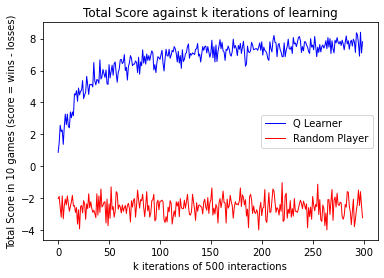

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(meansQ)),meansQ,lw=1,c='b')
plt.plot(range(0,len(meansRandom)),meansRandom,lw=1,c='r')
plt.legend(('Q Learner','Random Player'))
plt.title('Total Score against k iterations of learning')
plt.xlabel('k iterations of 500 interactions')
plt.ylabel('Total Score in 10 games (score = wins - losses)')
plt.show()

The QLearning agent seems to be learning as the score increases per iteration. Not only that, the agent is learning efficiently as at about the 40000th (k=80) interaction, the score begins to converge up to 8. Additionally, the QLearning agent scores consistently higher than the random agent. It is worth mentioning that the random agent has the advantage of playing first and thus it makes it harder for the QLearning agent to achieve the perfect 10. Thus, 8 has a similar meaning to the optimal.

The QTable ended up having 4768 entries on the last agent, multiplying this by the 5 possible actions we get 23840 pairs after (kn=300\*500) 150 000 interactions. Alpha and epsilon are supposed to begin at higher values and decrease over time until they reach 0 (negligible value), aiming for alpha to encourage learning (values new data more) and epsilon to avoid overfitting. However the Q-Learning we have implemented does not account for that.


## Part 2
We continue by building an agent that acts according to the Minimax policy.

Minimax is a decision rule used for minimizing the possible loss for a worst case scenario or when dealing with gains, maximizing the minimum gain. Our agent's purpose is to maximize the score, assuming that the opponent is trying to minimize the score.

In [16]:
import math
import copy as cp
import connect 

minimaxTable={}

#Alpha is the best already explored branch reward for the maximizer
#Beta is the best already explored branch reward for the minimizer
def minimaxAlphaBeta(state,alpha,beta,isMaximising,r):
    state._verbose = False
    if np.array_str(state.grid) in minimaxTable:
        if isMaximising:
            val, action = minimaxTable[np.array_str(state.grid)][0]
            #print(val)
            return val
        else:
            val, action = minimaxTable[np.array_str(state.grid)][1]
            return val
    else:
        minimaxTable[np.array_str(state.grid)]=[(-math.inf,-1),(math.inf,-1)]
        
    if state.grid_is_full():
        if isMaximising:
            val,action = minimaxTable[np.array_str(state.grid)][0]
            minimaxTable[np.array_str(state.grid)][0]=(0,action)
        else:
            val,action = minimaxTable[np.array_str(state.grid)][0]
            minimaxTable[np.array_str(state.grid)][1]=(0,action)
        return 0
    if r!=0:
        if isMaximising:
            val,action = minimaxTable[np.array_str(state.grid)][0]
            minimaxTable[np.array_str(state.grid)][0]=(-1,action)
            return -1
        else:
            val,action = minimaxTable[np.array_str(state.grid)][0]
            minimaxTable[np.array_str(state.grid)][1]=(1,action)
            return 1  
    
    
    if isMaximising:
        maxVal = -math.inf
        bestAction=-1
        a_a = state.available_actions
        
        for i in range(0,len(a_a)):
            child = cp.deepcopy(state)
            rr,over = child.act(a_a[i])
            newVal = minimaxAlphaBeta(child,alpha,beta,False,rr)
            if maxVal < newVal:
                maxVal = newVal
                bestAction=a_a[i]
            
            alpha = max(alpha,maxVal)
            
            #pruning takes places here
            if beta<=alpha:
                break
        
        minimaxTable[np.array_str(state.grid)][0]=(maxVal,bestAction)
        return maxVal
    else:
        minVal = math.inf
        bestAction=-1
        a_a = state.available_actions
        for i in range(0,len(a_a)):
            child = cp.deepcopy(state)
            rr,over = child.act(a_a[i])
            newVal = minimaxAlphaBeta(child,alpha,beta,True,rr)
            if minVal > newVal:
                minVal=newVal
                bestAction=a_a[i]
            
            beta = min(beta,minVal)
            
            #pruning takes places here
            if beta<=alpha:
                break
                
        minimaxTable[np.array_str(state.grid)][1]=(minVal,bestAction)
        return minVal

env = connect.Connect(starting_player = 'x',verbose=False)
env.reset()
env.act(action=1)
print(env.grid[::-1])
    
state_value = minimaxAlphaBeta(cp.deepcopy(env),-math.inf,math.inf,True,0)
num_branches = len(minimaxTable)

print(state_value," ",num_branches)

[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' 'x' ' ' ' ' ' ']]
-1   2364


In [17]:
#---NOTE: First agent takes much longer to execute, because he is acting on an empty table,
#---following agents run much faster so please be patient! (I do use pruning don't worry)
import numpy as np
import connect
import random
env = connect.Connect(starting_player = 'x',verbose=False)

import copy as cp
import matplotlib.pyplot as plt

debug=False
debugt=False

agents=30
kIterations=300
n=500
m=10
learn=True
interactions=0
resultsMM=np.zeros(kIterations)
debug=False
minimaxTable.clear()
for t in range(0,agents):
    
    for k in range(0,kIterations):
        
        totalScore=0
        for i in range(0,m):        
            env.reset()
            while not env.grid_is_full():
                r,over = env.act(action=random.choice(env.available_actions))
                if debug:
                    print(env.grid[::-1])
                    print("")
                
                if r==-1:
                    totalScore-=1
                    break
                    
                if env.grid_is_full():
                    break
                
                
                minimaxAlphaBeta(env,-math.inf,math.inf,True,0)
                val,a=minimaxTable[np.array_str(env.grid)][0]
                r,over =env.act(action=a)
                if debug:
                    print(env.grid[::-1])
                    print("")
                if r==1:
                    totalScore+=1
                    break
                if env.grid_is_full():
                    break

                #env.change_turn()
                
        resultsMM[k]+=totalScore

    print(t)
        
meansMM = resultsMM/agents

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


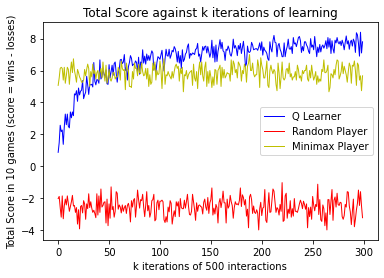

In [19]:
### Write all your code for Exercise 2 (B) in or above this cell.

#---To plot the following graph it is assumed that the cells above these have been run already

plt.plot(range(0,len(meansQ)),meansQ,lw=1,c='b')
plt.plot(range(0,len(meansRandom)),meansRandom,lw=1,c='r')
plt.plot(range(0,len(meansMM)),meansMM,lw=1,c='y')
plt.legend(('Q Learner','Random Player','Minimax Player'))
plt.title('Total Score against k iterations of learning')
plt.xlabel('k iterations of 500 interactions')
plt.ylabel('Total Score in 10 games (score = wins - losses)')
plt.show()

It is obvious that the best policy is not Random, but concerning the other two policies it depends. Minimax policy is consistently good scoring an average of 4.5 from k=0, which is much better than what Q learning starts with, however if the situation allows the agent to train long enough(k=25, which means 12500 interactions), then Q learning is better than the minimax player (in the long run) converging to an average score of 8. Theoritically minimax should be scoring better than the others, which would be true, if the enemy played optimally, however as he plays randomly, and the algorithm does not account for it, Q learning scores better in the long run.